In [1]:
import ROOT
import os
%run ../src/plotting_toolkit.py

Welcome to JupyROOT 6.22/06


In [2]:
PROJECT_NAME = "test4"
PROJECT_PATH = "/volatile/clas12/users/gmat/solid.data/coherent_deuteron_threshold/projects/"
TARGET_TYPE  = "d"
PLOT_DIR = f"./plots/{PROJECT_NAME}/kinematic_coverage"
PLOT_DIR_PNG = f"{PLOT_DIR}/png"
PLOT_DIR_PDF = f"{PLOT_DIR}/pdf"
try:
    os.makedirs(PLOT_DIR)
    os.makedirs(PLOT_DIR_PNG)
    os.makedirs(PLOT_DIR_PDF)
    print(f"Created directory: {PLOT_DIR}")
except:
    pass

In [3]:
bh_tree, photo_tree, electro_tree = get_tchains(PROJECT_NAME,PROJECT_PATH,"acc")

beam_energy, integrated_luminosity, bh_events, days = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"bh")
_, _, photo_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"photoproduction")
_, _, electro_events, _                               = get_beamE_lumi_events_days(PROJECT_NAME,PROJECT_PATH,"electroproduction")

luminosity = get_lumi_from_integrated(integrated_luminosity,TARGET_TYPE,days)

In [4]:
evtgen_dict = {
    "bh" : {
        "name" : "Bethe-Heitler",
        "ttree": bh_tree,
    },
    "photo" : {
        "name" : "J/#Psi Photoproduction",
        "ttree": photo_tree
    },
    "electro" : {
        "name" : "J/#Psi Electroproduction",
        "ttree": electro_tree
    }
}

particle_dict = {
    "ePlus" : {
        "name" : "Decay Positron",
        "type" : "e+",
        "branch" : "ePlus"
    },
    "eMinus" : {
        "name" : "Decay Electron",
        "type" : "e-",
        "branch" : "eMinus"
    },
    "eOut" : {
        "name" : "Scattered Electron",
        "type" : "e-",
        "branch" : "eOut"
    },
    "hOut" : {
        "name" : "Scattered "+("Deuteron" if TARGET_TYPE=="d" else "Proton"),
        "type" : TARGET_TYPE,
        "branch" : "hOut"
    }
}

plot_dict = {
    "p" : {
        "name" : ["P [GeV]"],
        "draw_name": ["P()"],
        "dimensions": 1,
        "hist" : {"ePlus": ROOT.TH1F("hist","",100,1,8),
                  "eMinus": ROOT.TH1F("hist","",100,1,8),
                  "eOut": ROOT.TH1F("hist","",100,0,15),
                  "hOut": ROOT.TH1F("hist","",100,0,2)}
    },
    "p.vs.theta" : {
        "name" : ["P [GeV]","Lab #Theta [deg]"],
        "draw_name": ["P()","Theta()*180/3.1415"],
        "dimensions": 2,
        "hist" : {"ePlus": ROOT.TH2F("hist","",100,1,8,100,0,40),
                  "eMinus": ROOT.TH2F("hist","",100,1,8,100,0,40),
                  "eOut": ROOT.TH2F("hist","",100,0,5,100,0,40),
                  "hOut": ROOT.TH2F("hist","",100,0,2,100,0,40)}
    }
}

Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: hist (Potential memory leak).


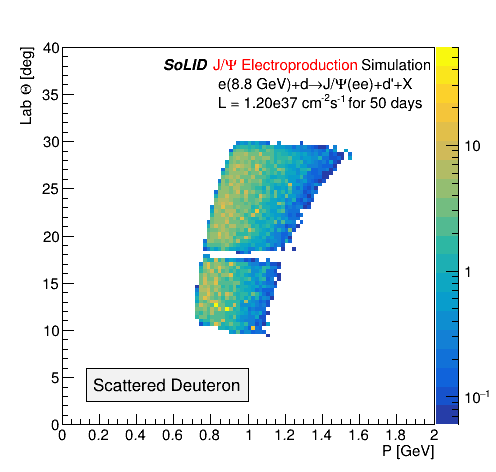

In [5]:
plot_number = 20000 # I have no idea why setting this to a high value  prevents errors 
ROOT.gErrorIgnoreLevel = ROOT.kError
for plot, plot_values in plot_dict.items():
    for evtgen, evtgen_values in evtgen_dict.items():
        for particle, particle_values in particle_dict.items():

            c = ROOT.TCanvas("c","c",500,500)
            ROOT.gStyle.SetOptStat(0)
            ROOT.gPad.SetRightMargin(0.125)
            ROOT.gPad.SetLeftMargin(0.125)
            tree = evtgen_values["ttree"]
            h    = plot_values["hist"][particle].Clone()
            h.SetName(f"hist_{plot_number}")
            weight_str = f"acc_ePlus*acc_eMinus*acc_hOut*weight*psf*flux*{integrated_luminosity/eval(evtgen+'_events')}"
            #weight_str = f"weight*psf*flux*acc_hOut*{integrated_luminosity/eval(evtgen+'_events')}"
            if evtgen != "bh":
                weight_str += "*decay_weight"
            if plot_values["dimensions"] == 2:
                h_title = f";{plot_values['name'][0]};{plot_values['name'][1]}"
                draw_str = f"{particle}.{plot_values['draw_name'][1]}:{particle}.{plot_values['draw_name'][0]}>>hist_{plot_number}"
                option_str = "colz"
                ROOT.gPad.SetLogz()
            else:
                draw_str = f"{particle}.{plot_values['draw_name'][0]}>>hist_{plot_number}"
                h_title = f";{plot_values['name'][0]};Counts"
                option_str = "hist"
            
            tree.Draw(draw_str, weight_str, "goff")
            h.SetTitle(h_title)
            h.Draw(option_str)
            
            dy = 0.04
            x1 = 0.33 if evtgen!="bh" else 0.4
            x2 = 0.44
            y  = 0.85 
            latex = ROOT.TLatex()
            latex.SetTextSize(dy-0.005)
            latex.SetTextFont(42)
            latex.DrawLatexNDC(x1,y,"#bf{#it{SoLID}} #color[2]{"+evtgen_values["name"]+"} Simulation")
            latex.DrawLatexNDC(x2,y-dy,f"e({beam_energy} GeV)+d#rightarrow"+("J/#Psi(ee)" if evtgen!="bh" else "(e+ + e-)") + "+d'+X")
            latex.DrawLatexNDC(x2,y-2*dy,f"L = {luminosity} cm^{{-2}}s^{{-1}} for {days:0.0f} days")
            pave = ROOT.TPaveText(0.175,0.15,0.5,0.22,"brNDC")
            pave.SetTextFont(42)
            pave.SetBorderSize(1)
            pave.AddText(particle_values["name"])
            pave.Draw("same")
            plot_name = f"{evtgen}_{particle}_{plot}"
            c.SaveAs(f"{PLOT_DIR_PNG}/{plot_name}.png")
            c.SaveAs(f"{PLOT_DIR_PDF}/{plot_name}.pdf")
            c.Draw()
            plot_number+=1
            

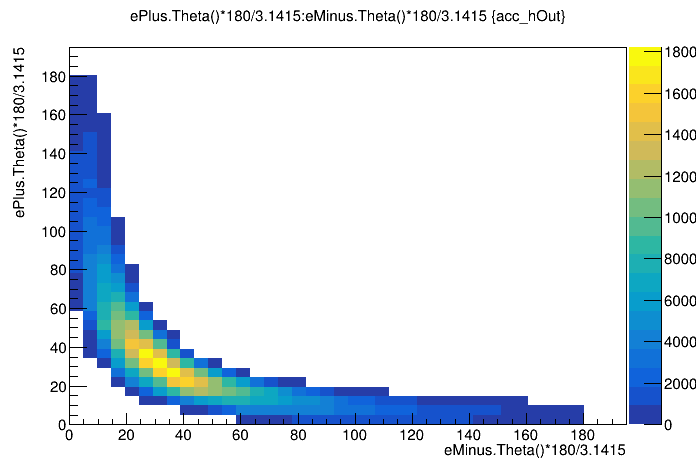

In [31]:
c=ROOT.TCanvas()
photo_tree.Draw("ePlus.Theta()*180/3.1415:eMinus.Theta()*180/3.1415","acc_hOut","colz")
c.Draw()